In [1]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from bgan_nogen import BGANNG, FixedSizeDataset
from datasets import DigitsDataset

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [179]:
data = DigitsDataset()
trainloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

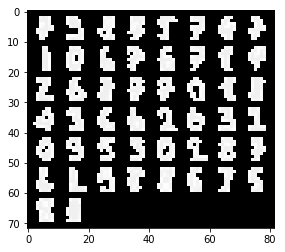

In [180]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images = data.inverse_transform(dataiter.next())
images = torch.from_numpy(images)
# images = images.view(-1, 1, 8, 8)

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [181]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [182]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, num_samples, shape=None, init=None):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples, init)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples, init):
        if init is None:
            z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        else:
            z = torch.from_numpy(init).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]


class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.x_dim = x_dim
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        output = self.network(input.view(-1, 64))
        return output

In [183]:
batch_size = 50

In [278]:
# prior = FactorizedNormalPrior(std=5.)
# init = data[0].numpy().reshape([1, -1])
# gen = GeneratorNetwork(1, init=init)
# disc = DiscriminatorNetwork(2, 2, 100)
# gen.apply(weights_init)
# disc.apply(weights_init)
# bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-4, num_data=len(data), disc_lr=1e-3, observed_gen=100)
# samples = []

In [279]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork(x_dim=64, K=2, h_dim=200)
init = np.copy(data[0].numpy()[:, None])
gen = GeneratorNetwork(1, init=init)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-6, num_data=len(data), disc_lr=5e-5, observed_gen=200)
samples = []

In [293]:
# init = np.copy(data[0].numpy()[:, None])
# gen = GeneratorNetwork(1, init=init)
# gen.apply(weights_init)
# bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-6, num_data=len(data), disc_lr=1e-4, observed_gen=100)

In [294]:
gen.forward()

Variable containing:
(0 ,0 ,.,.) = 
  0.0000 -0.3350 -0.0431  0.2741 -0.6645 -0.8441 -0.4097 -0.1250
 -0.0591 -0.6240  0.4830  0.7596 -0.0584  1.1277  0.8796 -0.1304
 -0.0446  0.1114  0.8959 -0.8607 -1.1496  0.5155  1.9060 -0.1142
 -0.0334  0.4865  0.4699 -1.4999 -1.6141  0.0764  1.5418 -0.0472
  0.0000  0.7647  0.0526 -1.4476 -1.7367  0.0436  1.4396  0.0000
 -0.0613  0.8106  0.6301 -1.1225 -1.0662  0.6610  0.8185 -0.0887
 -0.0354  0.7421  1.1507 -0.8687  0.1101  0.5376 -0.7574 -0.2098
 -0.0236 -0.2991  0.0867  0.2083 -0.3668 -1.1466 -0.5057 -0.1960
[torch.FloatTensor of size 1x1x8x8]

In [295]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(100000):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_.float()
        bgan.step(batch)
        
        if not i%100:
            bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.z_v.data.numpy()))
    if not epoch%100:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
if old_samples is not None:
    samples = np.vstack([old_samples, np.vstack(samples)])
else:
    samples = np.array(samples)

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got nan at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/THNN/generic/BCECriterion.c:32

In [282]:
samples[0].shape

(1, 1, 8, 8)

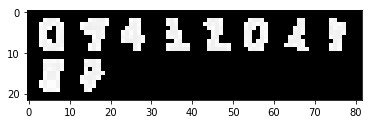

In [283]:
batch_samples_ = batch[:10]
batch_np = data.inverse_transform(batch_samples_)
imshow(torchvision.utils.make_grid(torch.from_numpy(batch_np)))

In [284]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [285]:
indices = (np.linspace(0, 1, 100) * (len(fake_samples)-1)).astype(int)

In [288]:
# fake_samples_ = torch.from_numpy(fake_samples[indices]).view(-1, 1, 8, 8)
fake_samples_ = torch.from_numpy(fake_samples[-100:]).view(-1, 1, 8, 8)
fake_np = data.inverse_transform(fake_samples_)

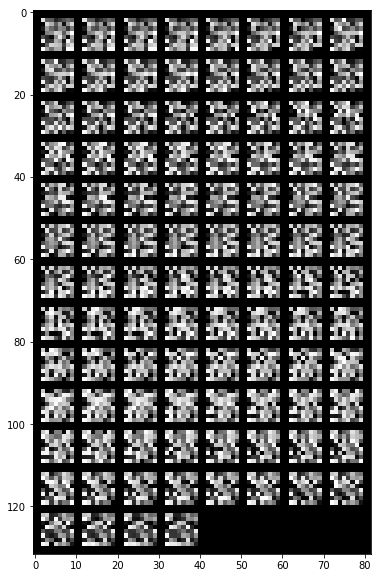

In [289]:
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_np)))

In [290]:
sample_probs = disc(Variable(torch.from_numpy(fake_np)))[:, 0].data.numpy()

In [291]:
sample_probs

array([  2.67747234e-33,   3.58155570e-33,   4.75062230e-33,
         6.43709964e-33,   8.44373829e-33,   1.13958028e-32,
         1.53115809e-32,   2.06448958e-32,   2.79651135e-32,
         3.81256282e-32,   5.05753447e-32,   6.35771703e-32,
         7.55579616e-32,   8.73530306e-32,   9.73824542e-32,
         1.04852227e-31,   1.15706307e-31,   1.29272875e-31,
         1.42276676e-31,   1.51377647e-31,   1.62439202e-31,
         1.79447500e-31,   1.99144659e-31,   2.16100225e-31,
         2.39294233e-31,   2.72129951e-31,   2.95895015e-31,
         3.12038996e-31,   3.32087781e-31,   3.59519328e-31,
         3.83911189e-31,   4.25450526e-31,   4.80746956e-31,
         5.46868936e-31,   6.54052157e-31,   7.53832443e-31,
         8.23689110e-31,   9.31611905e-31,   1.04881490e-30,
         1.13806087e-30,   1.12018612e-30,   1.07655769e-30,
         1.07642623e-30,   1.16487146e-30,   1.27109129e-30,
         1.32795211e-30,   1.35987929e-30,   1.39073724e-30,
         1.40608986e-30,

In [292]:
disc(Variable(batch))[:, 0]

Variable containing:
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 0.9804
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 0.9977
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 0.9985
 1.0000
 1.0000
 1.0000
 1.0000
[torch.FloatTensor of size 47]

In [235]:
for i, data_ in enumerate(trainloader, 0):
    batch = data_.float()
    print(batch.size())
    if i == 3:
        break

torch.Size([50, 1, 8, 8])
torch.Size([50, 1, 8, 8])
torch.Size([50, 1, 8, 8])
torch.Size([50, 1, 8, 8])


In [236]:
batch.size()

torch.Size([50, 1, 8, 8])

In [237]:
disc(Variable(batch))

Variable containing:
 1.0000e+00  8.1250e-13
 1.0000e+00  1.6372e-10
 1.0000e+00  1.2922e-06
 1.0000e+00  8.2848e-12
 1.0000e+00  4.9995e-11
 1.0000e+00  1.1527e-13
 1.0000e+00  6.0619e-08
 9.9998e-01  2.1351e-05
 1.0000e+00  1.5221e-06
 1.0000e+00  3.2569e-07
 1.0000e+00  2.6773e-08
 1.0000e+00  1.4610e-11
 1.0000e+00  1.3165e-15
 1.0000e+00  1.0850e-08
 1.0000e+00  2.3006e-09
 1.0000e+00  4.8273e-06
 1.0000e+00  1.6907e-15
 1.0000e+00  1.8743e-08
 1.0000e+00  2.4161e-11
 1.0000e+00  1.9429e-07
 1.0000e+00  3.4197e-06
 9.9995e-01  5.0964e-05
 1.0000e+00  1.1106e-07
 9.9997e-01  2.7274e-05
 1.0000e+00  8.3024e-10
 1.0000e+00  5.5720e-07
 1.0000e+00  4.3055e-09
 1.0000e+00  5.8191e-11
 1.0000e+00  3.7285e-11
 9.9979e-01  2.0645e-04
 1.0000e+00  1.0106e-11
 1.0000e+00  1.6989e-07
 1.0000e+00  6.6276e-09
 1.0000e+00  2.5986e-09
 1.0000e+00  2.3446e-10
 1.0000e+00  1.8856e-11
 1.0000e+00  6.8658e-11
 1.0000e+00  5.5742e-07
 9.9499e-01  5.0117e-03
 1.0000e+00  1.8915e-08
 1.0000e+00  1.5050